In [1]:
%matplotlib inline
from modsim import *
import numpy as np
import pandas as pd

In [2]:
"""  Team 4

    h: heat transfer coefficient, 10 in this case, for static air cooling
    (related website: https://link.springer.com/article/10.1007/s00231-015-1652-x)
    k_f: the cryoscopic constant, For water, KF = 1.853 K·kg/mol;
    num_ions: the van 't Hoff factor (number of ion particles per individual molecule of solute, e.g. i = 2 for NaCl, 3 for BaCl2).
    (related website: https://en.wikipedia.org/wiki/Freezing-point_depression)
    
    max_soluability for NaCl: 35.65g/mol = 6.15 mole/kg
    A: 686.966 cm^2 = 0.0686966 m^2, surface area of a 500mL water bottle
    (related website: https://www.bottleyourbrand.com/answers/sizing/arrowhead-water-bottle-label-size
    
    T_init: -25Celsius, Initial Temperature of the water bottle, set in Northern Siberia
    (related website: https://en.wikipedia.org/wiki/Siberia)
    k_water: 0.0387
    (related_website: http://jwilson.coe.uga.edu/EMAT6680Fa2014/Gieseking/Exploration%2012/Newton%27s%20Law%20of%20Cooling.htm)
    k_ice: twice k_water
"""
k_f = 1.853 #K*Kg/mol
num_ions = 2 #Number of Ions in NaCl
A = 0.0686966
T_init = -25
T_env = 20
T_end = 4 #Temprature 
latent_heat = 334
h = 10
k_water, k_ice = 0.0384, 0.0774
molality_array = linspace(0, 6.147, 10)
freezing_point_array = 0 - molality_array * k_f * num_ions
freezing_point_array

array([  0.      ,  -2.531198,  -5.062396,  -7.593594, -10.124792,
       -12.65599 , -15.187188, -17.718386, -20.249584, -22.780782])

# Newton's cooling
The section below employs Newton's cooling to calculate temperature

In [3]:
ice = System(T_init=-25, T_env=20, T_end=4, k=k_ice, T=0)
water = System(T_init=0, T_env=20, T_end=4, k=k_water, T=0)

def newton_cooling(system, t):
    """Calculates the change in temperature over time"""
    e=2.71828
    T=system.T
    T = system.T_env + (system.T_init - system.T_env)*e**(-system.k*t)
    
    system.T=T
    return system.T

def run_simulation(system, t):
    results=TimeSeries()
    for i in range(t):
        x=newton_cooling(system, i)
        results[i]=x
    return results

run_simulation(ice, 50)

,value
0,-25.000000
1,-21.648383
2,-18.546396
3,-15.675445
4,-13.018325
5,-10.559107
6,-8.283053
7,-6.176521
8,-4.226884
9,-2.422456


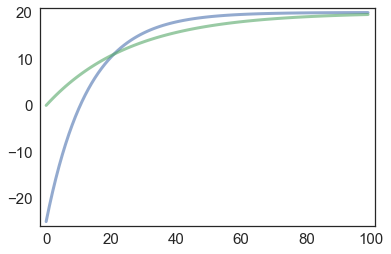

In [4]:
def plot_results(system, t):
    y=run_simulation(system, t)
    plot(y)
    
plot_results(ice, 100)
plot_results(water, 100)

# Melting
The section below calculates the time it takes for water at each salt level to melt

In [39]:
def melting_at(T_fpt):
    dQ = 500 * latent_heat
    dt = dQ / (10 * A *(T_fpt - T_env))
    return -dt

melting_at(0)

12154.895584352065

In [40]:
def get_melting_time(freezing_point_array, update_func):
    arrary_length = len(freezing_point_array)
    sweep_fpt = TimeSeries()
    #sweep_fpt.columns('Time(s)')
    for i in range(0, arrary_length):
        sweep_fpt.loc[freezing_point_array[i]] = update_func(freezing_point_array[i])/60
    return sweep_fpt

In [41]:
len(freezing_point_array)

10

In [42]:
results_in_minutes = get_melting_time(freezing_point_array, melting_at)
results_in_minutes

,value
0.000000,202.581593
-2.531198,179.823188
-5.062396,161.661792
-7.593594,146.832336
-10.124792,134.494932
-12.655990,124.070097
-15.187188,115.145088
-17.718386,107.417954
-20.249584,100.662702
-22.780782,94.706821


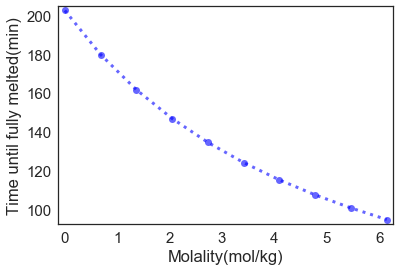

In [43]:
plot(molality_array, results_in_minutes, 'bo:')
decorate(xlabel = 'Molality(mol/kg)',
         ylabel = 'Time until fully melted(min)',
         legend = False)

In [44]:
a = np.array(results_in_minutes)
np.diff(results_in_minutes)

array([-22.75840473, -18.16139585, -14.82945664, -12.33740352,
       -10.42483488,  -8.92500937,  -7.72713383,  -6.7552527 ,  -5.95588058])

In [45]:
results_in_minutes

,value
0.000000,202.581593
-2.531198,179.823188
-5.062396,161.661792
-7.593594,146.832336
-10.124792,134.494932
-12.655990,124.070097
-15.187188,115.145088
-17.718386,107.417954
-20.249584,100.662702
-22.780782,94.706821


# Newton's Cooling(stop at Freezing Pts)

In [46]:
def run_simulation_ice(system, t, freezing_point_array):
    time2stop = TimeSeries()
    temperature = DataFrame(columns = freezing_point_array)
    for freezing_pt in freezing_point_array:
        results=TimeSeries()
        recorded = False
        for i in range(t):
            x=newton_cooling(system, i)
            results[i] = x
            if x > freezing_pt and not recorded:
                time2stop[freezing_pt] = i
                recorded = True
        temperature[freezing_pt] = results
    return time2stop, temperature

In [47]:
ice = System(T_init=-25, T_env=20, T_end=4, k=k_ice, T=0)
%time time2stop_ice, temperature_solid = run_simulation_ice(ice, 100, freezing_point_array)

Wall time: 549 ms


In [48]:
time2stop_ice

,value
0.000000,11
-2.531198,9
-5.062396,8
-7.593594,7
-10.124792,6
-12.655990,5
-15.187188,4
-17.718386,3
-20.249584,2
-22.780782,1


In [32]:
temperature_solid.columns = ['salt0', 'salt1', 'salt2', 'salt3', 'salt4', 'salt5', 'salt6', 'salt7', 'salt8', 'salt9']
temperature_solid

,salt0,salt1,salt2,salt3,salt4,salt5,salt6,salt7,salt8,salt9
0,-25.000000,-25.000000,-25.000000,-25.000000,-25.000000,-25.000000,-25.000000,-25.000000,-25.000000,-25.000000
1,-21.648383,-21.648383,-21.648383,-21.648383,-21.648383,-21.648383,-21.648383,-21.648383,-21.648383,-21.648383
2,-18.546396,-18.546396,-18.546396,-18.546396,-18.546396,-18.546396,-18.546396,-18.546396,-18.546396,-18.546396
3,-15.675445,-15.675445,-15.675445,-15.675445,-15.675445,-15.675445,-15.675445,-15.675445,-15.675445,-15.675445
4,-13.018325,-13.018325,-13.018325,-13.018325,-13.018325,-13.018325,-13.018325,-13.018325,-13.018325,-13.018325
5,-10.559107,-10.559107,-10.559107,-10.559107,-10.559107,-10.559107,-10.559107,-10.559107,-10.559107,-10.559107
6,-8.283053,-8.283053,-8.283053,-8.283053,-8.283053,-8.283053,-8.283053,-8.283053,-8.283053,-8.283053
7,-6.176521,-6.176521,-6.176521,-6.176521,-6.176521,-6.176521,-6.176521,-6.176521,-6.176521,-6.176521
8,-4.226884,-4.226884,-4.226884,-4.226884,-4.226884,-4.226884,-4.226884,-4.226884,-4.226884,-4.226884
9,-2.422456,-2.422456,-2.422456,-2.422456,-2.422456,-2.422456,-2.422456,-2.422456,-2.422456,-2.422456


# Liquid

In [33]:
def newton_cooling_above_freezing(system, t, freezing_pt):
    """Calculates the change in temperature over time"""
    e=2.71828
    T_init = freezing_pt
    T=system.T
    T = system.T_env + (T_init - system.T_env)*e**(-system.k*t)
    system.T=T
    return system.T

def run_simulation_water(system, t, freezing_point_array):
    time2stop = TimeSeries()
    temperature = DataFrame(columns = freezing_point_array)
    for freezing_pt in freezing_point_array:
        results = TimeSeries()
        recorded = False
        for i in range(t):
            x=newton_cooling_above_freezing(system, i, freezing_pt)
            results[i] = x
            if x > 4 and not recorded:
                time2stop[freezing_pt] = i
                recorded = True
        temperature[freezing_pt] = results
    return time2stop, temperature

In [34]:
water = System(T_init=0, T_env=20, T_end=4, k=k_water, T=0)
time2stop, temperature_liquid = run_simulation_water(water, 100, freezing_point_array)

In [35]:
time2stop

,value
0.000000,6
-2.531198,9
-5.062396,12
-7.593594,15
-10.124792,17
-12.655990,19
-15.187188,21
-17.718386,23
-20.249584,25
-22.780782,26


In [36]:
temperature_liquid.columns = ['salt0', 'salt1', 'salt2', 'salt3', 'salt4', 'salt5', 'salt6', 'salt7', 'salt8', 'salt9']
temperature_liquid

,salt0,salt1,salt2,salt3,salt4,salt5,salt6,salt7,salt8,salt9
0,0.000000,-2.531198,-5.062396,-7.593594,-10.124792,-12.655990,-15.187188,-17.718386,-20.249584,-22.780782
1,0.753441,-1.682402,-4.118244,-6.554087,-8.989930,-11.425772,-13.861615,-16.297457,-18.733300,-21.169143
2,1.478498,-0.865581,-3.209661,-5.553740,-7.897820,-10.241899,-12.585979,-14.930058,-17.274137,-19.618217
3,2.176241,-0.079532,-2.335306,-4.591079,-6.846852,-9.102625,-11.358398,-13.614171,-15.869945,-18.125718
4,2.847698,0.676905,-1.493889,-3.664683,-5.835476,-8.006270,-10.177063,-12.347857,-14.518650,-16.689444
5,3.493860,1.404845,-0.684170,-2.773186,-4.862201,-6.951216,-9.040232,-11.129247,-13.218262,-15.307278
6,4.115680,2.105363,0.095045,-1.915273,-3.925591,-5.935909,-7.946227,-9.956545,-11.966863,-13.977181
7,4.714075,2.779490,0.844905,-1.089680,-3.024265,-4.958850,-6.893435,-8.828021,-10.762606,-12.697191
8,5.289927,3.428222,1.566517,-0.295189,-2.156894,-4.018599,-5.880305,-7.742010,-9.603715,-11.465421
9,5.844086,4.052515,2.260944,0.469372,-1.322199,-3.113770,-4.905341,-6.696912,-8.488483,-10.280054


In [37]:
sum_time = results_in_minutes + time2stop + time2stop_ice

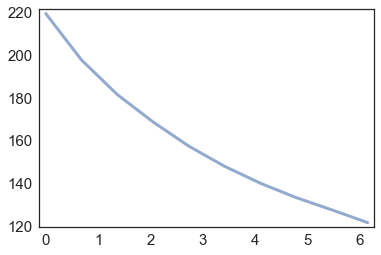

In [38]:
plot(molality_array, sum_time)